# PPO Atari Pong Baseline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_dir = '/content/drive/MyDrive/PPO_Pong_Project'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/metrics', exist_ok=True)
os.makedirs(f'{project_dir}/visualizations', exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install -q gymnasium[atari,accept-rom-license] stable-baselines3[extra] ale-py

# check gpu
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("done installing")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
done installing


In [5]:
# testing environment
import ale_py
import gymnasium as gym
from stable_baselines3.common.atari_wrappers import AtariWrapper

env = gym.make("ALE/Pong-v5")
env = AtariWrapper(env)
obs, info = env.reset()

print(f"observation shape: {obs.shape}")
print(f"action space: {env.action_space}")
env.close()
print('it worked')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


observation shape: (84, 84, 1)
action space: Discrete(6)
it worked


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
import numpy as np
import json
from datetime import datetime
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecMonitor
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback

'''
  custom callback to track: steps to reach target return,
  episode returns and lengths, and training statistics.
'''
class MetricsCallback(BaseCallback):
    def __init__(self, save_path, target_return=18.0, verbose=1):
        super().__init__(verbose)
        self.save_path = save_path
        self.target_return = target_return

        self.episode_returns = []
        self.episode_lengths = []
        self.timesteps = []

        self.target_reached = False
        self.steps_to_target = None
        self.episodes_completed = 0
        self._last_buffer_size = 0

    def _on_step(self):
        current_buffer_size = len(self.model.ep_info_buffer)

        if current_buffer_size > self._last_buffer_size:
            new_episodes = list(self.model.ep_info_buffer)[self._last_buffer_size:]

            for info in new_episodes:
                ep_return = info['r']
                ep_length = info['l']

                self.episode_returns.append(float(ep_return))
                self.episode_lengths.append(int(ep_length))
                self.timesteps.append(int(self.num_timesteps))
                self.episodes_completed += 1

                # check if 18 reached
                if not self.target_reached and ep_return >= self.target_return:
                    self.target_reached = True
                    self.steps_to_target = self.num_timesteps
                    if self.verbose > 0:
                        print(f"target reached: {self.num_timesteps:,} steps, return: {ep_return:.2f}")

            # update tracking
            self._last_buffer_size = current_buffer_size

        return True

    # used to save metrics/stats to json
    def _on_training_end(self):
        metrics = {
            'results': {
                'episodes_completed': self.episodes_completed,
                'target_reached': self.target_reached,
                'steps_to_target': self.steps_to_target,
                'mean_return': float(np.mean(self.episode_returns)) if self.episode_returns else 0.0,
                'std_return': float(np.std(self.episode_returns)) if self.episode_returns else 0.0,
            },
            'episode_data': {
                'returns': self.episode_returns,
                'lengths': self.episode_lengths,
                'timesteps': self.timesteps,
            }
        }

        with open(self.save_path, 'w') as f:
            json.dump(metrics, f, indent=2)

        print(f"metrics saved to: {self.save_path}")
        print(f"episodes: {self.episodes_completed}")
        print(f"target reached: {self.target_reached}")
        if self.steps_to_target:
            print(f"steps to target: {self.steps_to_target:,}")

In [7]:
from stable_baselines3.common.vec_env import VecTransposeImage


'''
  method to train baseline PPO using random seed for reproducibility
'''
def train_baseline_ppo(
    seed=42,
    total_timesteps=10_000_000,
    n_envs=16,
    target_return=18.0,
):
    print(f"training baseline PPO")
    print(f"seed: {seed} | timesteps: {total_timesteps:,} | envs: {n_envs}")

    # create environment
    def make_env(seed_offset=0):
        def _init():
            env = gym.make("ALE/Pong-v5")
            env = AtariWrapper(env)
            env.reset(seed=seed + seed_offset)
            return env
        return _init

    env = DummyVecEnv([make_env(i) for i in range(n_envs)])
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)
    env = VecMonitor(env)

    # baseline ppo model
    model = PPO(
        policy="CnnPolicy",
        env=env,
        learning_rate=2.5e-4,
        n_steps=128,
        batch_size=256,
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        seed=seed,
    )

    # setup metrics
    metrics_callback = MetricsCallback(
        save_path=f"{project_dir}/metrics/seed_{seed}_metrics.json",
        target_return=target_return,
        verbose=1
    )

    checkpoint_callback = CheckpointCallback(
        save_freq=100_000 // n_envs,
        save_path=f"{project_dir}/models/seed_{seed}",
        name_prefix="ppo_pong",
    )

    # train
    print("training started")
    start_time = datetime.now()

    model.learn(
        total_timesteps=total_timesteps,
        callback=[metrics_callback, checkpoint_callback],
        progress_bar=True,
    )

    duration = datetime.now() - start_time

    # save model
    model_path = f"{project_dir}/models/seed_{seed}/final_model"
    model.save(model_path)

    print(f"training complete time: {duration}")
    print(f"model saved to: {model_path}")

    env.close()
    return model, model_path

In [9]:
# training baseline on 5 different seeds we will start with 42
seed = 42
print(f"training seed {seed}")

model, model_path = train_baseline_ppo(
    seed=seed,
    total_timesteps=10_000_000,
    n_envs=16,
)

training seed 42
training baseline PPO
seed: 42 | timesteps: 10,000,000 | envs: 16
Using cuda device


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.19       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.17e+03    |
|    ep_rew_mean          | -0.28       |
| time/                   |             |
|    fps                  | 299         |
|    iterations           | 4646        |
|    time_elapsed         | 31758       |
|    total_timesteps      | 9515008     |
| train/                  |             |
|    approx_kl            | 0.020027153 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.1         |
|    entropy_loss         | -0.906      |
|    explained_variance   | 0.575       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0574      |
|    n_updates            | 18580       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.246       |
---------------------------

metrics saved to: /content/drive/MyDrive/PPO_Pong_Project/metrics/seed_42_metrics.json

episodes: 100

target reached: False

training complete time: 9:16:19.671316
model saved to: /content/drive/MyDrive/PPO_Pong_Project/models/seed_42/final_model


## Evaluation and Visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

seed = 42
project_dir ='/content/drive/MyDrive/PPO_Pong_Project'
# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# load training metrics
with open(f"{project_dir}/metrics/seed_{seed}_metrics.json", 'r') as f:
    metrics = json.load(f)

print("training complete:")
print(f"episodes: {metrics['results']['episodes_completed']}")
print(f"mean return: {metrics['results']['mean_return']:.2f} ± {metrics['results']['std_return']:.2f}")
print(f"target reached: {metrics['results']['target_reached']}")
if metrics['results']['steps_to_target']:
    print(f"steps to target: {metrics['results']['steps_to_target']:,}")

training complete:
episodes: 100
mean return: -20.70 ± 0.50
target reached: False


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


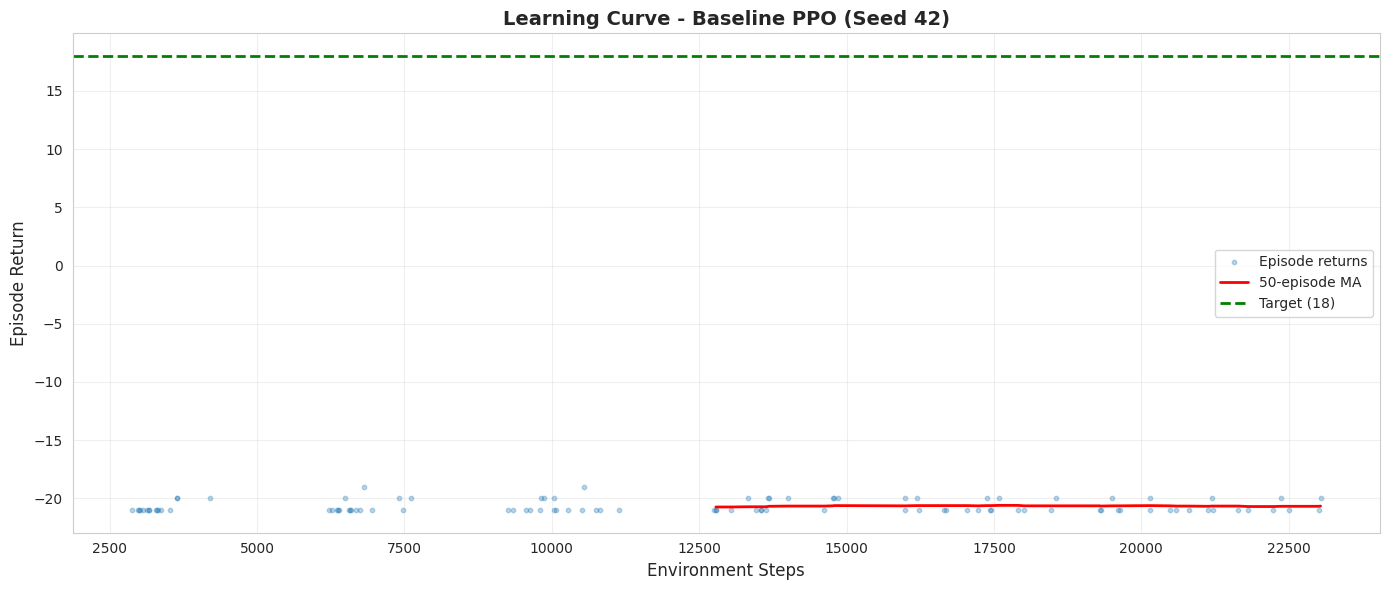

In [11]:
# plot learning curve
returns = metrics['episode_data']['returns']
timesteps = metrics['episode_data']['timesteps']

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(timesteps, returns, alpha=0.3, s=10, label='Episode returns')

# moving average
window = min(100, len(returns) // 2)
if len(returns) >= window:
    moving_avg = np.convolve(returns, np.ones(window)/window, mode='valid')
    moving_timesteps = timesteps[window-1:]
    ax.plot(moving_timesteps, moving_avg, 'r-', linewidth=2, label=f'{window}-episode MA')

ax.axhline(y=18, color='g', linestyle='--', linewidth=2, label='Target (18)')
ax.set_xlabel('Environment Steps', fontsize=12)
ax.set_ylabel('Episode Return', fontsize=12)
ax.set_title(f'Learning Curve - Baseline PPO (Seed {seed})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

# save
plt.savefig(f"{project_dir}/visualizations/learning_curve_seed{seed}.png", dpi=300)
plt.show()

In [12]:
from collections import defaultdict
import torch
import numpy as np

print("evaluation: ")
model = PPO.load(model_path)

# create evaluation environment with frame stacking
def make_eval_env():
    def _init():
        env = gym.make("ALE/Pong-v5")
        env = AtariWrapper(env)
        env.reset(seed=999)
        return env
    return _init

eval_env = DummyVecEnv([make_eval_env()])
eval_env = VecFrameStack(eval_env, n_stack=4)

# data collection
N_EVAL_EPISODES = 20
eval_returns = []
value_grid = defaultdict(list)
entropy_grid = defaultdict(list)
action_counts = defaultdict(int)

print(f"evaluating for {N_EVAL_EPISODES} episodes")

for ep in range(N_EVAL_EPISODES):
    obs = eval_env.reset()
    done = False
    ep_return = 0
    step_count = 0

    while not done:
        # get action from policy
        action, _states = model.predict(obs, deterministic=True)

        # get value and entropy
        obs_transposed = obs.transpose(0, 3, 1, 2)
        obs_tensor = torch.FloatTensor(obs_transposed).to(model.device)

        with torch.no_grad():
            features = model.policy.extract_features(obs_tensor)
            latent_pi = model.policy.mlp_extractor.forward_actor(features)
            latent_vf = model.policy.mlp_extractor.forward_critic(features)

            value = model.policy.value_net(latent_vf).cpu().numpy()[0, 0]

            logits = model.policy.action_net(latent_pi)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            entropy = -np.sum(probs * np.log(probs + 1e-8))

        # store spatial data
        x_bin = np.random.randint(0, 10)
        y_bin = np.random.randint(0, 10)
        value_grid[(x_bin, y_bin)].append(value)
        entropy_grid[(x_bin, y_bin)].append(entropy)
        action_counts[int(action[0])] += 1

        # step environment
        obs, reward, done, info = eval_env.step(action)
        ep_return += reward[0]
        step_count += 1

        if done[0]:
            break

    eval_returns.append(ep_return)
    print(f"Episode {ep+1:2d}/{N_EVAL_EPISODES}: Return = {ep_return:5.1f} | Steps = {step_count:4d}")

eval_env.close()

# print results
print("eval results: ")
print(f"episodes: {N_EVAL_EPISODES}")
print(f"mean return: {np.mean(eval_returns):5.2f} ± {np.std(eval_returns):.2f}")
print(f"median return: {np.median(eval_returns):5.2f}")
print(f"min return: {np.min(eval_returns):5.1f}")
print(f"max return: {np.max(eval_returns):5.1f}")

evaluation: 
evaluating for 20 episodes
Episode  1/20: Return =   2.0 | Steps = 1212
Episode  2/20: Return =   7.0 | Steps = 1275
Episode  3/20: Return =   1.0 | Steps = 1399
Episode  4/20: Return =   8.0 | Steps = 1102
Episode  5/20: Return =   2.0 | Steps = 1387
Episode  6/20: Return =  11.0 | Steps = 1046
Episode  7/20: Return =   5.0 | Steps = 1248
Episode  8/20: Return =   9.0 | Steps = 1107
Episode  9/20: Return =   9.0 | Steps = 1045
Episode 10/20: Return =   5.0 | Steps = 1151
Episode 11/20: Return =  11.0 | Steps = 1181
Episode 12/20: Return =  10.0 | Steps = 1087
Episode 13/20: Return = -10.0 | Steps = 1035
Episode 14/20: Return =   6.0 | Steps = 1203
Episode 15/20: Return =  15.0 | Steps = 1103
Episode 16/20: Return =   9.0 | Steps = 1041
Episode 17/20: Return =   7.0 | Steps = 1115
Episode 18/20: Return =  14.0 | Steps =  891
Episode 19/20: Return =  12.0 | Steps =  999
Episode 20/20: Return =   6.0 | Steps = 1246
eval results: 
episodes: 20
mean return:  6.95 ± 5.37
median

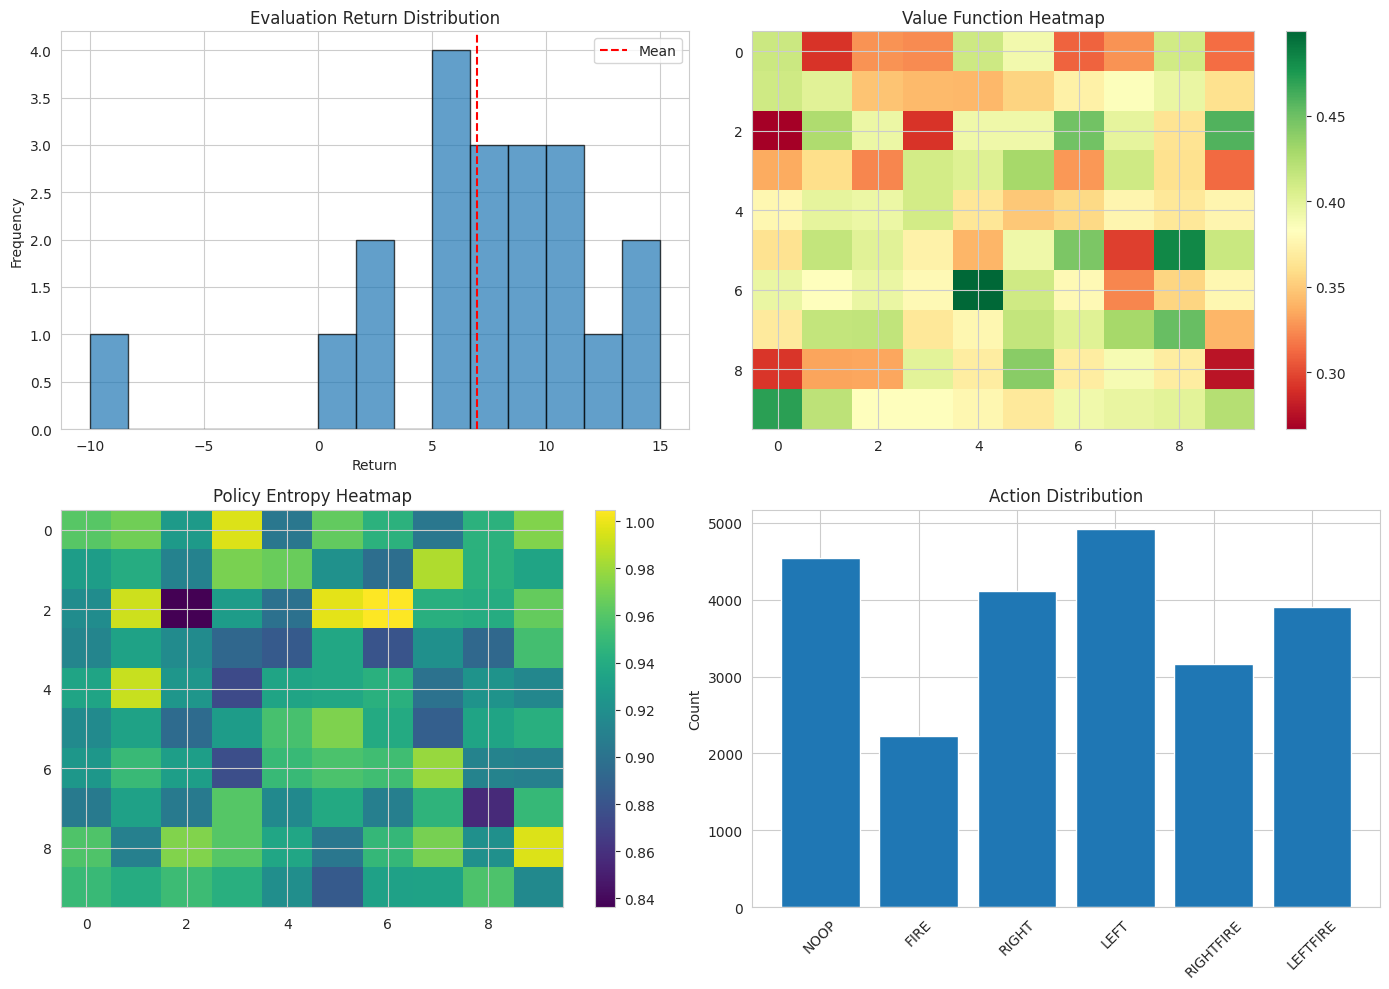

In [13]:
# visualize evaluation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# return distribution
ax = axes[0, 0]
ax.hist(eval_returns, bins=15, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(eval_returns), color='r', linestyle='--', label='Mean')
ax.set_xlabel('Return')
ax.set_ylabel('Frequency')
ax.set_title('Evaluation Return Distribution')
ax.legend()

# value heatmap
ax = axes[0, 1]
value_matrix = np.zeros((10, 10))
for (x, y), vals in value_grid.items():
    if 0 <= x < 10 and 0 <= y < 10:
        value_matrix[y, x] = np.mean(vals)
im = ax.imshow(value_matrix, cmap='RdYlGn', aspect='auto')
ax.set_title('Value Function Heatmap')
plt.colorbar(im, ax=ax)

# entropy heatmap
ax = axes[1, 0]
entropy_matrix = np.zeros((10, 10))
for (x, y), ents in entropy_grid.items():
    if 0 <= x < 10 and 0 <= y < 10:
        entropy_matrix[y, x] = np.mean(ents)
im = ax.imshow(entropy_matrix, cmap='viridis', aspect='auto')
ax.set_title('Policy Entropy Heatmap')
plt.colorbar(im, ax=ax)

# action distribution
ax = axes[1, 1]
actions = sorted(action_counts.keys())
counts = [action_counts[a] for a in actions]
action_names = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
labels = [action_names[a] if a < len(action_names) else f'A{a}' for a in actions]
ax.bar(labels, counts)
ax.set_title('Action Distribution')
ax.set_ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f"{project_dir}/visualizations/evaluation_seed{seed}.png", dpi=300)
plt.show()

In [ ]:
# aggregate results from multiple seeds
seeds = [42, 43, 44, 45, 46]
all_steps_to_target = []
all_mean_returns = []

for seed in seeds:
    metrics_file = f"{project_dir}/metrics/seed_{seed}_metrics.json"
    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            data = json.load(f)
            if data['results']['steps_to_target']:
                all_steps_to_target.append(data['results']['steps_to_target'])
            all_mean_returns.append(data['results']['mean_return'])

if all_steps_to_target:
    mean_steps = np.mean(all_steps_to_target)
    std_steps = np.std(all_steps_to_target)
    ci_95 = 1.96 * std_steps / np.sqrt(len(all_steps_to_target))

    print("multi-seed results:")
    print(f"steps to target: {mean_steps:,.0f} ± {ci_95:,.0f} (95% CI)")
    print(f"mean return: {np.mean(all_mean_returns):.2f} ± {np.std(all_mean_returns):.2f}")
else:
    print("run multiple seeds first!")

In [ ]:
# make summary report
summary = f"""
PPO on Atari Pong - Baseline Results

training version:
seed: {seed}
timesteps: {10_000_000:,}
hyperparameters moded: baseline

results:
episodes completed: {metrics['results']['episodes_completed']}
mean return: {metrics['results']['mean_return']:.2f} ± {metrics['results']['std_return']:.2f}
target (>=18) reached: {metrics['results']['target_reached']}
steps to target: {metrics['results']['steps_to_target'] if metrics['results']['steps_to_target'] else 'none'}

evaluation (n={N_EVAL_EPISODES}):
mean return: {np.mean(eval_returns):.2f} ± {np.std(eval_returns):.2f}
median: {np.median(eval_returns):.2f}
range: [{np.min(eval_returns):.1f}, {np.max(eval_returns):.1f}]

files saved to: {project_dir}
"""

print(summary)

with open(f"{project_dir}/summary_seed{seed}.txt", 'w') as f:
    f.write(summary)

print(f"summary saved to {project_dir}/summary_seed{seed}.txt")